In [72]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [73]:
from src.pipeline.dataloader import DataLoader, DataLoaderConfig
from src.pipeline.frame.filter import FrameFilters
from src.pipeline.frame.transformer import FrameTransformers
from src.pipeline.taskloader import TaskLoader, TaskFrame, TaskLoaderConfig
from src.pipeline.trainer import Trainer

from src.parsers.cv_parser import to_cv_params, parse_cv_result, fmt_cv_results, _fmt_regressor
from src.utils.test_result_store import TestResultStore
from src.visualizers.prediction_figures import PredictionFigures
from src.visualizers.test_figures import TestFigures
from src.visualizers.cv_figures import CVFigures

from src.settings.strategy import Strategy
from src.settings.tier import Tier

import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.utils import get_generator, get_project_root, make_path_if_not_exists

import pandas as pd
import numpy as np

In [74]:
DataLoader.DATA_FOLDER = './data/training/'
dl: DataLoader = DataLoader()
tl: TaskLoader = TaskLoader()

In [75]:
def get_dataset(
    data_config: DataLoaderConfig,
    task_config: TaskLoaderConfig,
    strategy:Strategy=Strategy.METABOLITE_CENTRIC,
    tier=Tier.TIER1,
):
    dl.prepare_dataloader(data_config),
    df = dl.get_dataframe()
    tl.prepare_taskloader(task_config)
    gen = tl.prepare_task(df).build(strategy)
    # tf: TaskFrame = next(gen)
    return gen

def save_fig(path: str, name: str, extra_artists = set()):
    make_path_if_not_exists(path)
    plt.savefig(f"{path}/{name}.png", bbox_inches='tight', bbox_extra_artists=extra_artists)
    plt.savefig(f"{path}/{name}.svg", bbox_inches='tight', bbox_extra_artists=extra_artists)



precursor_dataset_raw = next(get_dataset(
    data_config=DataLoaderConfig( additional_filters=["is_precursor"]),
    task_config=TaskLoaderConfig(),
    strategy=Strategy.ALL,
    tier=Tier.TIER0,
))


precursor_dataset = next(get_dataset(
    data_config=DataLoaderConfig(additional_transforms=["log_fold_change_protein"], additional_filters=["is_precursor"]),
    task_config=TaskLoaderConfig(),
    strategy=Strategy.ALL,
    tier=Tier.TIER0,
))


ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f3ea477f610>>])
ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f3ea477f7c0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f3ea477f610>>])


In [76]:
MODE = 'talk'
FIGSIZE = (0, 0)
DPI = 0

# Paper dimensions

# Presentation dimensions
LABEL_SIZE_TALK = 16
DPI_TALK = 96
FIGSIZE_TALK = (13.33, 7.5)
FONTSIZE_TALK = 18

def set_context(mode):
    if mode == 'talk':
        sns.set_context(
            "talk",
            rc={
                "font_size": FONTSIZE_TALK,
                "axes.labelsize": LABEL_SIZE_TALK,
                "facecolor": "white",
            }
        )
        sns.set_style(
            'whitegrid',
            rc={
                'axes.edgecolor': 'black'
            }
        )
        fig = plt.figure(figsize=FIGSIZE_TALK, dpi=DPI_TALK)
        return fig

# Visualizations
1. How many measures do I have per metabolite
2. What are the range for each precursor metabolite
3. For pyr, pep, dhap what are the knockouts that tricker the highest change

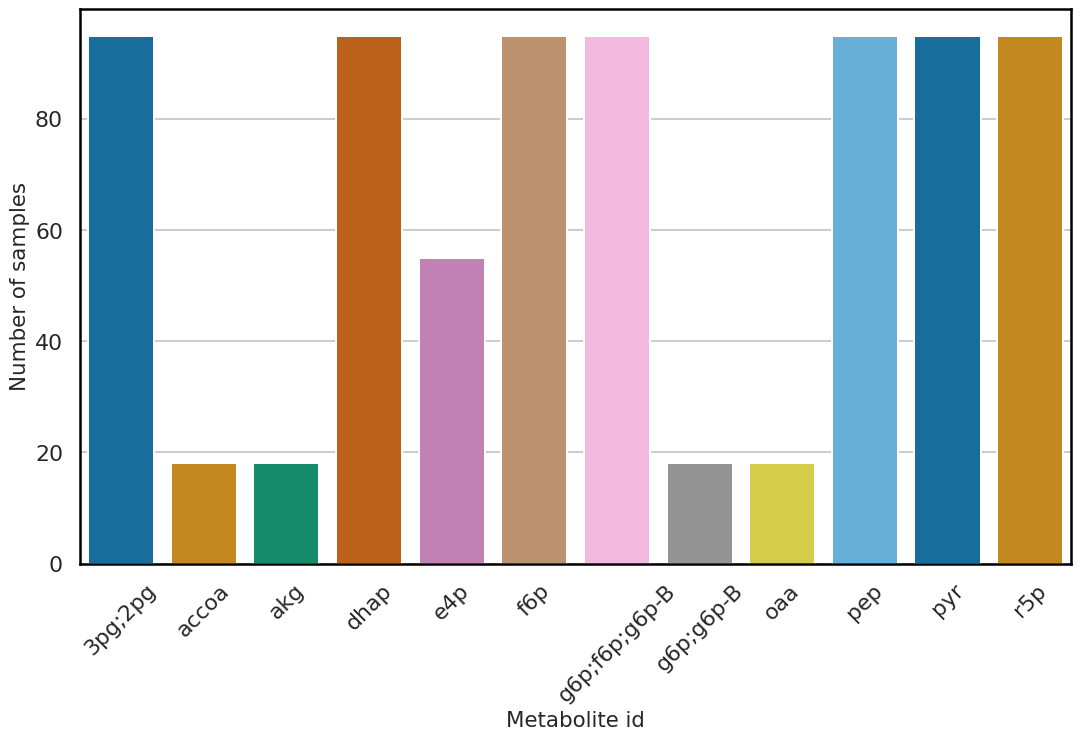

In [77]:
set_context(MODE)
g = sns.countplot(
    data=precursor_dataset.x.reset_index(),
    x='metabolite_id',
    palette='colorblind',
)

g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Number of samples")

save_fig(path=f"./images/{MODE}/explorative/", name="count_per_precursor_metabolite")

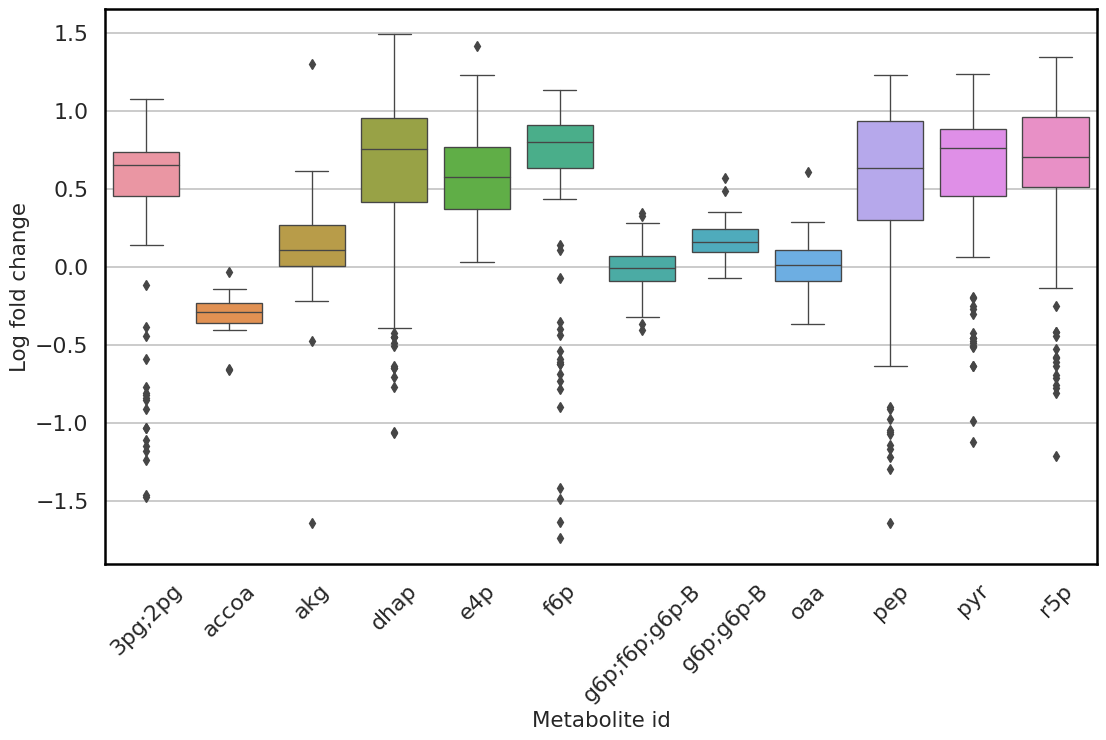

In [78]:
set_context(MODE)
g = sns.boxplot(
    data=precursor_dataset.y.reset_index(),
    x='metabolite_id',
    y='metabolite_concentration',
    linewidth=1,
)

g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Log fold change")

save_fig(path=f"./images/{MODE}/explorative/", name="boxplot_per_precursor_metabolite_fc")

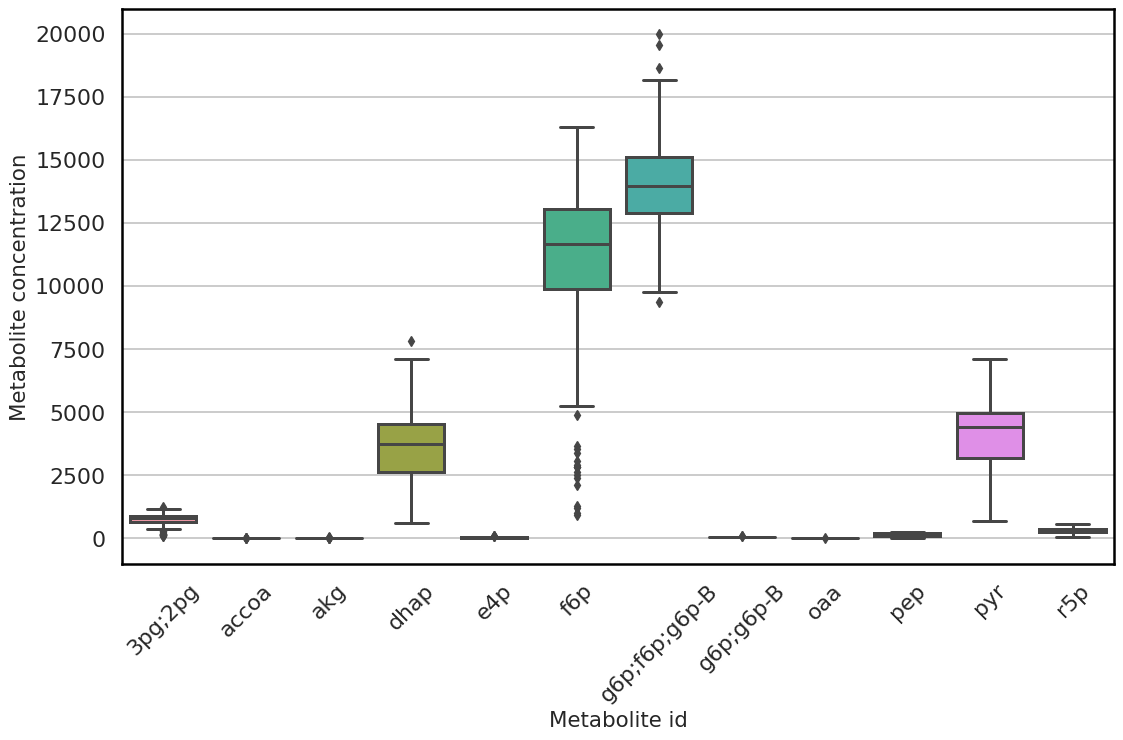

In [79]:
set_context(MODE)

g = sns.boxplot(
    data=precursor_dataset_raw.y.reset_index(),
    x='metabolite_id',
    y='metabolite_concentration'
)

g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Metabolite concentration")
save_fig(path=f"./images/{MODE}/explorative/", name="boxplot_per_precursor_metabolite")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


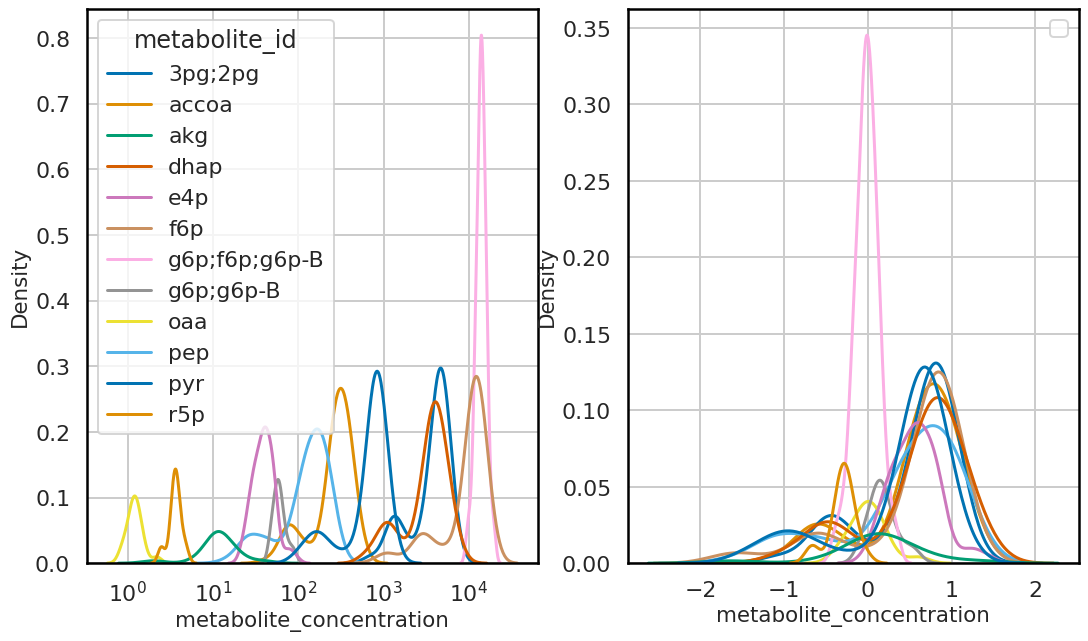

In [80]:
fig = set_context(MODE)

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sns.kdeplot(
    data=precursor_dataset_raw.y.reset_index(),
    x='metabolite_concentration',
    hue='metabolite_id',
    log_scale=(True),
    fill=False,
    ax=ax1,
    palette='colorblind',
)

sns.kdeplot(
    data=precursor_dataset.y.reset_index(),
    x='metabolite_concentration',
    hue='metabolite_id',
    fill=False,
    ax=ax2,
    palette='colorblind',
)

plt.legend()

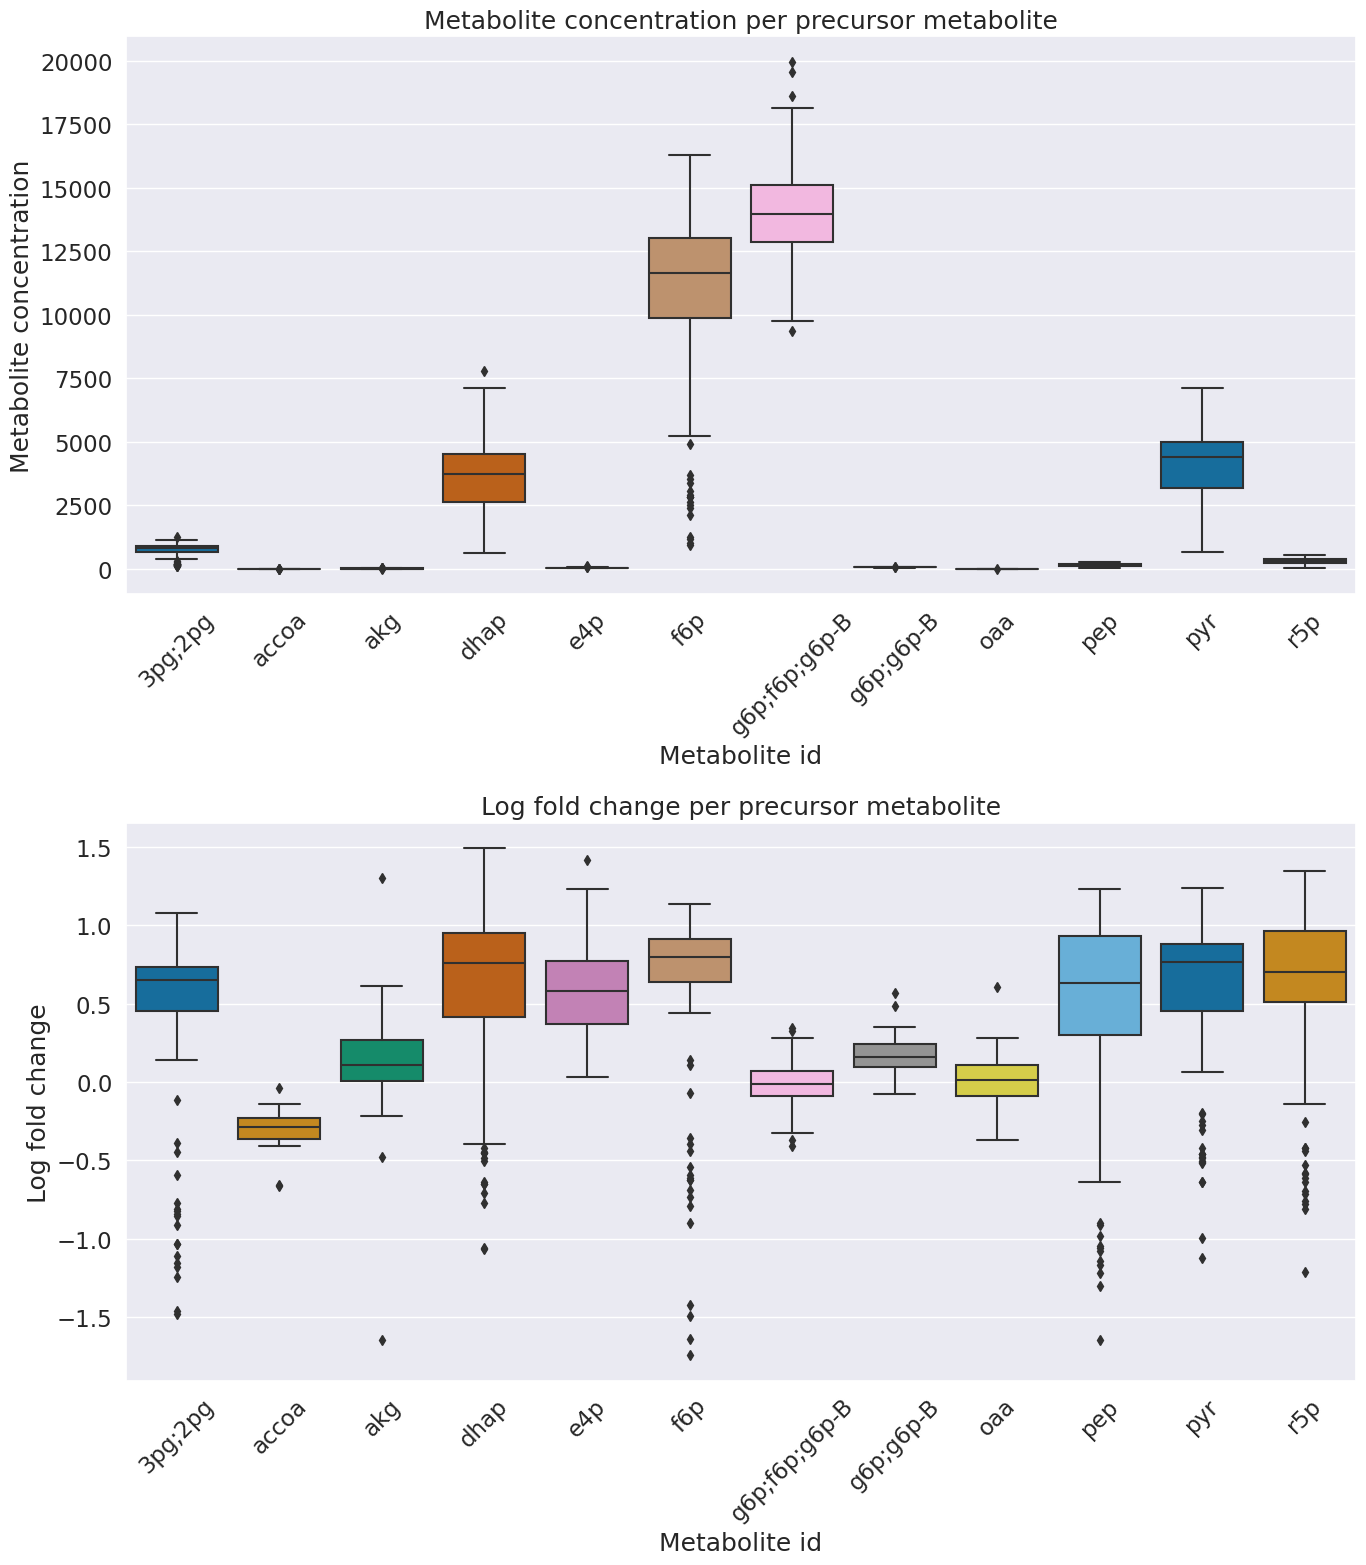

In [81]:
sns.set(font_scale=1.5)
fig, ((ax3, ax4)) = plt.subplots(nrows=2, ncols=1, figsize=(14, 16))

g3 = sns.boxplot(
    data=precursor_dataset_raw.y.reset_index().sort_values('metabolite_id'),
    x='metabolite_id',
    y='metabolite_concentration',
    ax=ax3,
    palette='colorblind',
)

g3.axes.set_xticklabels(g3.axes.get_xticklabels(), rotation=45)
g3.set(xlabel="Metabolite id", ylabel="Metabolite concentration", title="Metabolite concentration per precursor metabolite")

g4 = sns.boxplot(
    data=precursor_dataset.y.reset_index().sort_values('metabolite_id'),
    x='metabolite_id',
    y='metabolite_concentration',
    ax=ax4,
    palette='colorblind',
)

g4.axes.set_xticklabels(g4.axes.get_xticklabels(), rotation=45)
g4.set(xlabel="Metabolite id", ylabel="Log fold change", title="Log fold change per precursor metabolite")
plt.tight_layout()

plt.savefig('./images/explorative/boxplot_log_fold_transformation.svg')
plt.savefig('./images/explorative/boxplot_log_fold_transformation.png')

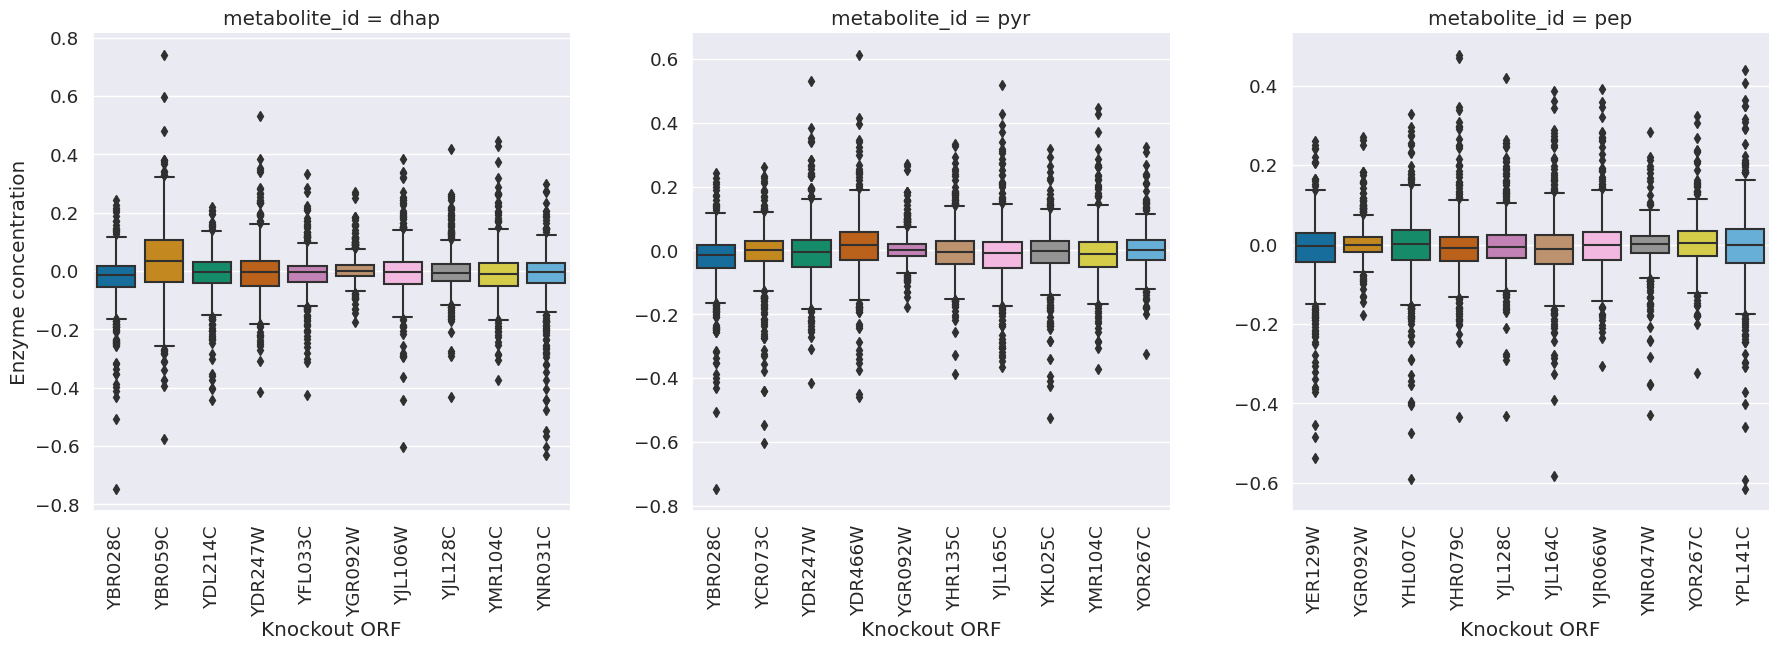

In [82]:
sns.set(font_scale=1.2)
_df_x = precursor_dataset.x[precursor_dataset.x.index.isin(['pep', 'pyr', 'dhap'], level=1)]
_df_y = precursor_dataset.y[_df_x.index].abs().sort_values(ascending=False).groupby('metabolite_id').head(10)
_df_x = _df_x.loc[_df_y.index]
_df = _df_x.T.stack([0, 1]).to_frame('enzyme_concentration').reset_index()

def mapper(*args, **kwargs):
    df = kwargs['data']
    sns.boxplot(
        data=df,
        y='enzyme_concentration',
        x='KO_ORF',
        palette='colorblind'
    )

g = sns.FacetGrid(
    _df, 
    col='metabolite_id', 
    col_wrap=10,
    sharex=False,
    sharey=False,
    height=6
)
g.map_dataframe(mapper)

for axes in g.axes.flatten():
    axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

g.set_axis_labels(x_var="Knockout ORF", y_var="Enzyme concentration")

plt.savefig('./images/explorative/effect_of_knockout_on_enzyme_concentration.svg', bbox_inches="tight")
plt.savefig('./images/explorative/effect_of_knockout_on_enzyme_concentration.png', bbox_inches="tight")

In [150]:
def get_train_test_metabolite_distrubtion(strategy: Strategy):
    trainer = Trainer()

    if strategy == Strategy.ALL:
        split_kwargs = dict(
            stratify='metabolite_id',
            shuffle=True
        )
    else:
        split_kwargs = dict(shuffle=False, stratify=None)

    gen = get_dataset(
        data_config=DataLoaderConfig(additional_filters=["is_precursor"], additional_transforms=["log_fold_change_protein"]),
        task_config=TaskLoaderConfig(),
        strategy=strategy,
        tier=Tier.TIER0,
    )

    if strategy == Strategy.ALL:
        tf = next(gen)

        _, _, y_train, y_test = trainer.do_train_test_split(tf, **split_kwargs)
    elif strategy == Strategy.METABOLITE_CENTRIC:
        splits = [trainer.do_train_test_split(tf, strategy=strategy, **split_kwargs) + [tf.frame_name] for tf in gen]
        y_train = pd.concat([split[2].to_frame().assign(metabolite_id=split[-1]) for split in splits])
        y_test = pd.concat([split[3].to_frame().assign(metabolite_id=split[-1]) for split in splits])
    else:
        splits = [trainer.do_train_test_split(tf, strategy=strategy, **split_kwargs) for tf in gen]
        y_train = pd.concat([split[2].to_frame() for split in splits])
        y_test = pd.concat([split[3].to_frame() for split in splits])

    _df = pd.concat([
        y_train.reset_index().assign(mode="train"),
        y_test.reset_index().assign(mode="test")
    ], axis=0)

    return _df

get_train_test_metabolite_distrubtion(strategy=Strategy.ONE_VS_ALL)

ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f3ea477f7c0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f3ea477f610>>])


,KO_ORF,metabolite_id,metabolite_concentration,mode
0,YHR082C,accoa,-0.303635,train
1,YDR490C,accoa,-0.260957,train
2,YJL164C,accoa,-0.176235,train
3,YNL298W,accoa,-0.370636,train
4,YHR079C,accoa,-0.381625,train
...,...,...,...,...
787,YKL198C,r5p,0.593886,test
788,YOR233W,r5p,0.690995,test
789,YOR351C,r5p,0.541401,test
790,YJL165C,r5p,0.985114,test


In [151]:
_df = pd.concat([
    get_train_test_metabolite_distrubtion(strategy=Strategy.ALL).assign(strategy=Strategy.ALL),
    get_train_test_metabolite_distrubtion(strategy=Strategy.METABOLITE_CENTRIC).assign(strategy=Strategy.METABOLITE_CENTRIC),
    get_train_test_metabolite_distrubtion(strategy=Strategy.ONE_VS_ALL).assign(strategy=Strategy.ONE_VS_ALL),
])
_df[
    (_df['strategy'] == Strategy.ONE_VS_ALL) &
    (_df['mode'] == 'test') &
    (_df['metabolite_id'] == 'oaa')
]

ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f3ea477f7c0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f3ea477f610>>])
ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f3ea477f7c0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f3ea477f610>>])
ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f3ea477f7c0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f3

,KO_ORF,metabolite_id,metabolite_concentration,mode,strategy
489,YJL164C,oaa,-0.089105,test,Strategy.ONE_VS_ALL
490,YOR267C,oaa,-0.006942,test,Strategy.ONE_VS_ALL
491,YPL140C,oaa,-0.148269,test,Strategy.ONE_VS_ALL
492,YAR018C,oaa,0.283743,test,Strategy.ONE_VS_ALL
493,YAL017W,oaa,0.191636,test,Strategy.ONE_VS_ALL
494,YPL141C,oaa,0.112654,test,Strategy.ONE_VS_ALL
495,YDR490C,oaa,0.032656,test,Strategy.ONE_VS_ALL
496,YNL298W,oaa,-0.053197,test,Strategy.ONE_VS_ALL
497,YBR097W,oaa,0.607377,test,Strategy.ONE_VS_ALL
498,YHR079C,oaa,0.029677,test,Strategy.ONE_VS_ALL


ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f3ea477f7c0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f3ea477f610>>])
ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f3ea477f7c0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f3ea477f610>>])
ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f3ea477f7c0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f3

<Figure size 1279.68x720 with 0 Axes>

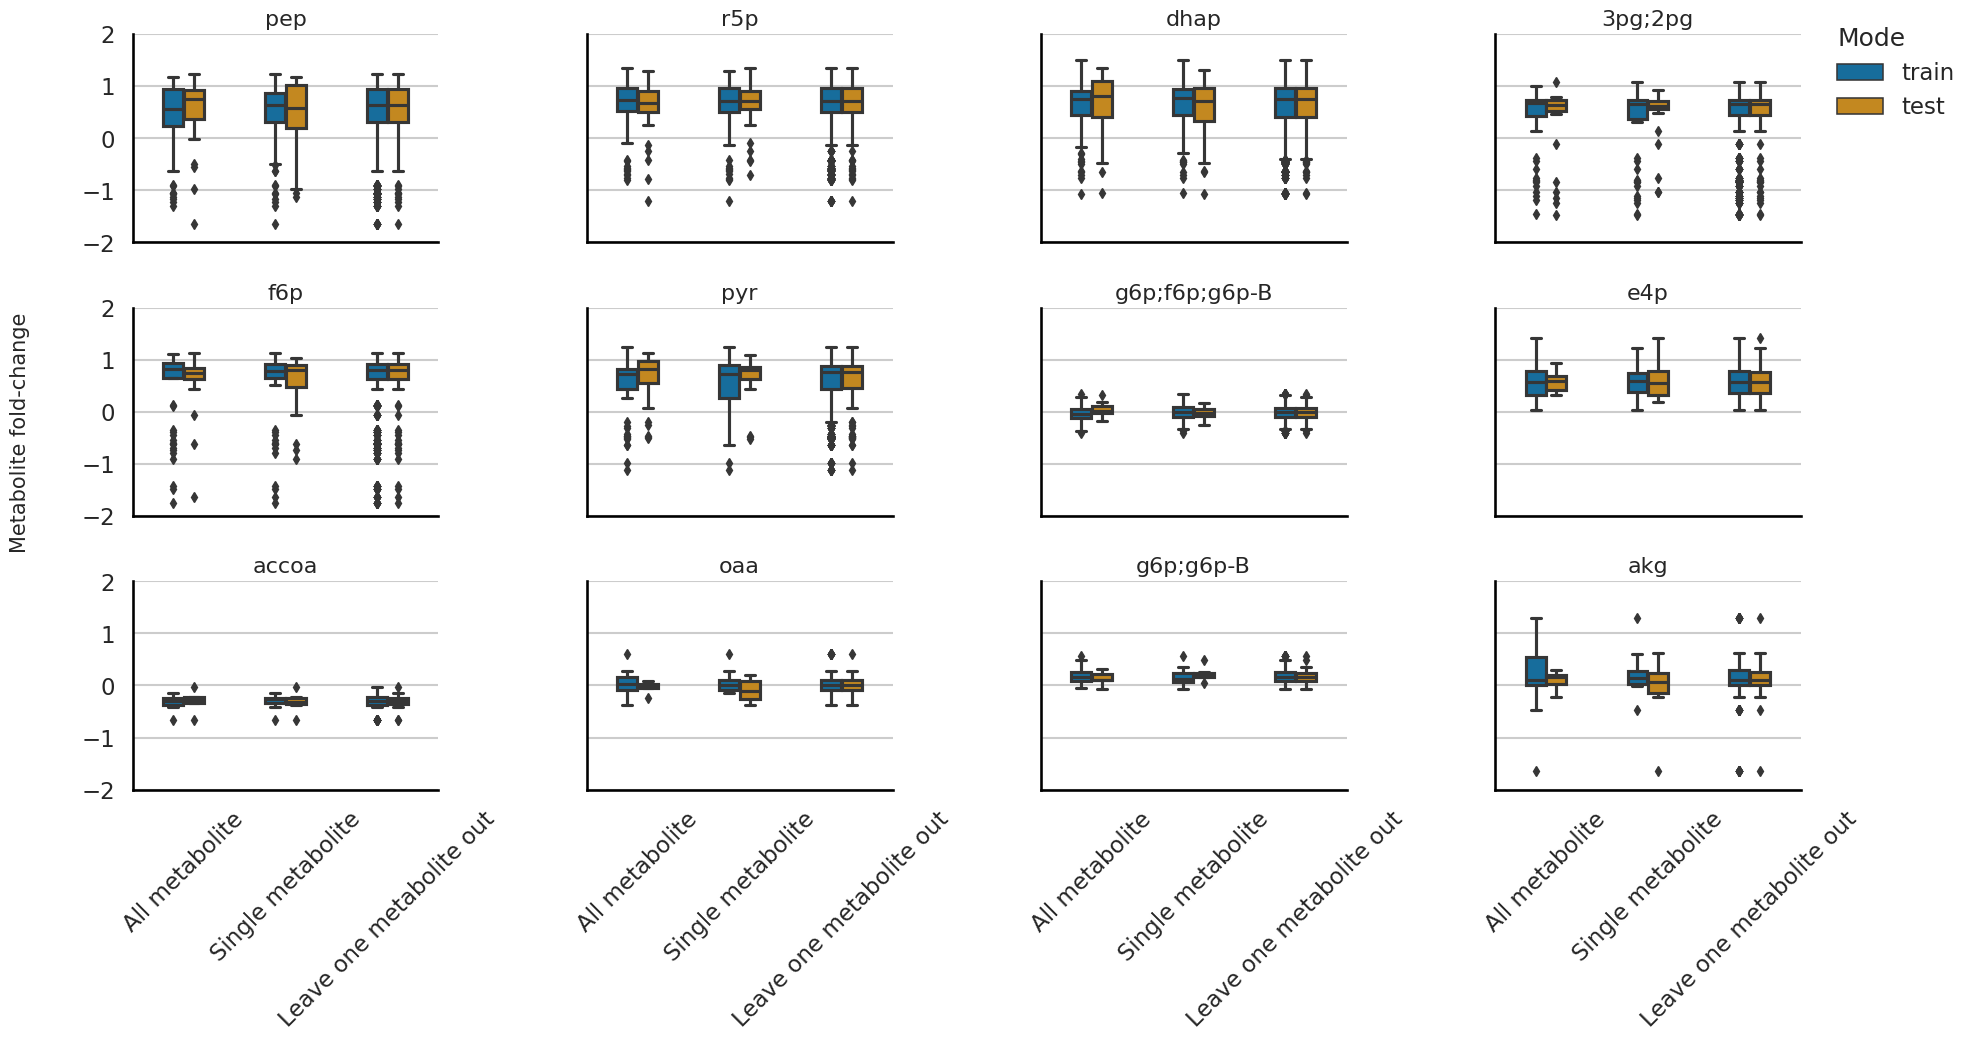

In [162]:
# Train test split plot
fig = set_context(MODE)
# ax2 = fig.add_subplot(gs[0, 2:])
# ax3 = fig.add_subplot(gs[1, 2:], sharex=ax2, sharey=ax2)

_df = pd.concat([
    get_train_test_metabolite_distrubtion(strategy=Strategy.ALL).assign(strategy=Strategy.ALL),
    get_train_test_metabolite_distrubtion(strategy=Strategy.METABOLITE_CENTRIC).assign(strategy=Strategy.METABOLITE_CENTRIC),
    get_train_test_metabolite_distrubtion(strategy=Strategy.ONE_VS_ALL).assign(strategy=Strategy.ONE_VS_ALL),
])

_df.strategy = _df.strategy.map({
    Strategy.ALL: 'All metabolite', 
    Strategy.METABOLITE_CENTRIC: 'Single metabolite',
    Strategy.ONE_VS_ALL: 'Leave one metabolite out', 
})

g = sns.FacetGrid(
    data=_df,
    col='metabolite_id',
    col_wrap=4,
    ylim=[-2, 2],
    aspect=1.5,
)

g.map_dataframe(
    sns.boxplot,
    x='strategy',
    y='metabolite_concentration',
    hue='mode',
    width=.4,
    palette='colorblind',
)

g.fig.text(0.0, 0.5, "Metabolite fold-change", rotation=90, fontsize=15, va='center', ha='center')

g.set_axis_labels(y_var="", x_var="")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# for axes in g.axes.flat:
#     print(axes)
#     _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
# plt.legend(loc='upper left', bbox_to_anchor=(1.01, 0.75), title='Architecture', alignment='left')
g.add_legend(title='Mode', alignment='left', bbox_to_anchor=(1.01, 0.9))

save_fig(path=f'./images/{MODE}/explorative/', name="fold_change_between_train_test_set")

